In [ ]:
!pip install pretrainedmodels

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import torch.nn.functional as F
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import pretrainedmodels
import os
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
import numpy as np
import pandas as pd
import os
import datetime as dt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models



%matplotlib inline

PyTorch Version:  1.3.0
Torchvision Version:  0.4.1


In [2]:
print('Train set:')
for cls in os.listdir('./data/train/train'):
    print('{}:{}'.format(cls, len(os.listdir(os.path.join('./data/train/train', cls)))))
im = Image.open('./data/train/train/cgm/train-cgm-738.jpg')
print(im.size)

Train set:
cgm:773
cmd:2658
healthy:316
cbb:466
cbsd:1443
(500, 500)


In [114]:
data_path = "./data/train/train"
test_path = "./data/test"
extraimage_path = "./data/extraimages"

In [115]:
# Transformations for both the training and testing data
mean=[0.4543, 0.5137, 0.3240]
std=[0.1949, 0.1977, 0.1661]

# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]


train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])

test_transforms = transforms.Compose([ transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])


# train_transform = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
#                                     transforms.RandomRotation(degrees=15),
#                                     transforms.RandomHorizontalFlip(),
#                                     transforms.CenterCrop(size=224),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean, std)])

# test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize([0.485, 0.456, 0.406],
#                                                          [0.229, 0.224, 0.225])])

# normalize = transforms.Normalize(mean=mean, std=std)

In [118]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16

train_data = datasets.ImageFolder(data_path, transform=train_transforms)
test_data = datasets.ImageFolder(test_path, transform=test_transforms)
extraimage_data = datasets.ImageFolder(extraimage_path, transform=train_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

unlabeled_loader = torch.utils.data.DataLoader(extraimage_data, batch_size=batch_size,
                                               num_workers=num_workers) # to make batch_size work, I had to moove all the unlabeled data in a 0 folder

In [119]:
for data,label in unlabeled_loader:
    print(label)
    break

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [121]:
# next(unlabeled_loader.__iter__())

In [122]:
# mean=[0.4543, 0.5137, 0.3240]
# std=[0.1949, 0.1977, 0.1661]

# inv_normalize = transforms.Normalize(
#    mean=[-0.4543/0.1949, -0.5137/0.1977, -0.3240/0.1661],
#    std=[1/0.1949, 1/0.1977, 1/0.1661]
# )

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std=[1/s for s in std]
)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = inv_normalize(img)# / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.figure(figsize=(20,20))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


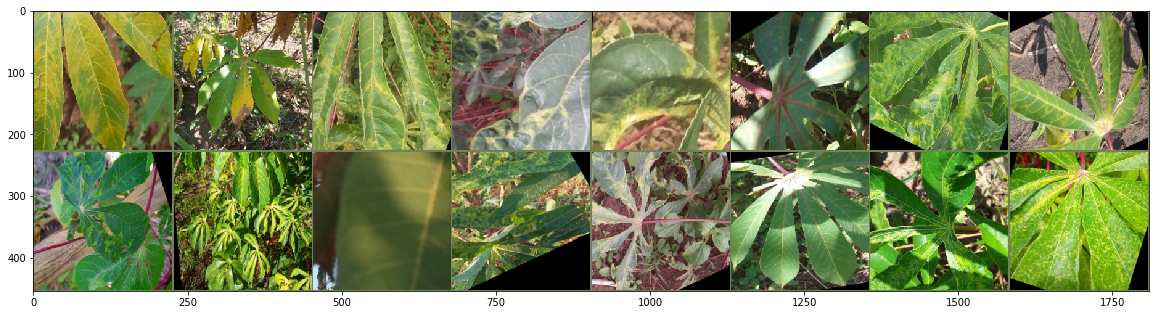

In [90]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=False)

In [140]:
class Additional(nn.Module):
    def __init__(self, modelA,in_features,nb_classes=5, freeze = False):
        super(Additional, self).__init__()
        self.modelA = modelA
        # Remove last linear layer
#         self.modelA.fc = nn.Identity() # for resnet
        self.modelA.last_linear = nn.Identity() #for re_renext
#         self.modelA.classifier = nn.Identity()    # densenet201
        for p in self.modelA.parameters():
            if freeze:
                p.requires_grad = False
            else :
                p.requires_grad = True
        
        # Create new classifier
        self.fc_1 = nn.Linear(in_features,256)
        self.fc_2 = nn.Linear(256,  512)
        self.fc_out = nn.Linear( 512, nb_classes)
        
        #Dropout
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        #model
        x = self.modelA(x.clone())  
        x = x.view(x.size(0), -1)
        
        #FC
        x  = self.dropout(self.fc_1(F.relu(x)))
        x = self.dropout(self.fc_2(F.relu(x)))
        x = self.fc_out(F.relu(x))
        
        return x

In [141]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [159]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [160]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [161]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'resnet18' # se_resnext101_32x4d, resnext101_64x4d, nasnetlarge
# resnet_model = torch.hub.load('pytorch/vision:v0.5.0', model_name, pretrained=True)
resnet_model = pretrainedmodels.resnet18(num_classes=1000, pretrained="imagenet")# todo : how to pretrained=False ?

# resnet_model = torchvision.models.resnet50(pretrained=True)
#---------------------------------------------

# num_fits = resnet_model.fc.in_features
num_fits = resnet_model.last_linear.in_features # se_resnext101_32x4d
# num_fits = resnet_model.classifier.in_features # densenet201
num_fits


model = Additional(resnet_model, num_fits, freeze = False)
model = model.to(device)
# model

#---------------------------------------------

In [162]:
model

Additional(
  (modelA): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [163]:
from sklearn.model_selection import KFold 

In [164]:
kfold=KFold(n_splits=5)

best_val_acc = 0.88

lr = 2e-4 # 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for i, (train_index, validate_index) in enumerate(kfold.split(train_data)):
    #print("train index:", train_index, "validate index:", validate_index)
    train_data = torch.utils.data.Subset(train_data, train_index)
    validation_data = torch.utils.data.Subset(train_data, validate_index)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False)
    valid_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False)
    
#     print("Number of Samples in Train: ",len(train))
#     print("Number of Samples in Valid: ",len(validation))
    
    epoch_num = 5
    
    print('------------------------------------------------------------')
    print(f'          ------------- Fold {i} -----------')
    print('------------------------------------------------------------')
    
    total_loss_val, total_acc_val = [],[]
    for epoch in range(1, epoch_num+1):
        loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
        loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, epoch)
        total_loss_val.append(loss_val)
        total_acc_val.append(acc_val)
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
            print('*****************************************************')

KeyboardInterrupt: 

In [147]:
# kfold=KFold(n_splits=5)
# # running_loss = 0.0
# # loss_test=0.0
# # epochs=10
# # total_acc=0
# # batch_size=64
# ################################################################################
# for i, data in enumerate(train_loader,0):
#   train,labels= data


# # total=0
# for cv,(train_index,test_index) in enumerate(kfold.split(train,labels)):
# #   x_train_fold   =  train[train_index]
# #   y_train_fold   =  labels[train_index]
# #   x_test_fold    =  train[test_index]
# #   y_test_fold    =  labels[test_index]

# #   train_last = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
# #   test_last = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)
# #   train_loader = torch.utils.data.DataLoader(train_last, batch_size = batch_size, shuffle = False)
# #   test_loader = torch.utils.data.DataLoader(test_last, batch_size = batch_size, shuffle = False)

# #   for epoch in range(epochs):
# #       print('\nEpoch {} / {} \nFold number {} / {}'.format(epoch + 1, epochs, cv + 1 , kfold.get_n_splits()))
# #       correct = 0
# #       net.train()
# #       for batch_index, (x_batch, y_batch) in enumerate(train_loader):
# #           optimizer.zero_grad()
# #           out = net(x_batch)
# #           #print(x_batch.shape)
# #           loss = criterion(out, y_batch)
# #           #print(loss)
# #           loss.backward()
# #           optimizer.step()
# #           pred = torch.max(out.data, dim=1)[1]
# #           correct+= (pred == y_batch).sum()
# #           if (batch_index + 1) % 32 == 0:
# #                     print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
# #                         (batch_index + 1)*len(x_batch), len(train_loader.dataset),
# #                         100.*batch_index / len(train_loader), loss.data, float(correct*100) / float(batch_size*(batch_index+1))))
# #   total_acc += float(correct)/float(batch_size*batch_index)
# # acc = (total_acc / kfold.get_n_splits())
# # print('\n\nTotal accuracy cross validation: {:.3f}%'.format(acc))

In [151]:
len(train)

8

In [ ]:
# for epoch in range(20):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 1000 == 0:  
#           # ...log the running loss
#             writer.add_scalar('training loss',
#                             running_loss / 1000,
#                             epoch * len(trainloader) + i)

#             # ...log a Matplotlib Figure showing the model's predictions on a
#             # random mini-batch
#             writer.add_figure('predictions vs. actuals',
#                             plot_classes_preds(net, inputs, labels),
#                             global_step=epoch * len(trainloader) + i)  # print every 2000 mini-batches

        
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss))
#             running_loss = 0.0

# print('Finished Training')

